## Imports are Necessary

In [1]:
import torch
import torch.utils.data

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor, MaskRCNN_ResNet50_FPN_Weights

import _utils as utils
import _transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches


## Root Path

In [2]:
root_path = '/home/aghosh57/Kerner-Lab/maskrcnn-rpn/dataset/'

## Dataset Structure

In [3]:
from _dataset import ParcelDataset

## Create the Model

In [4]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

## Some utility function

In [5]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

## Get the dataset

In [6]:
dataset = ParcelDataset(root_path, get_transform(train=False))

## Prepare the dataset

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Prepare the model with the desired weights

In [8]:
#Our dataset has two classes only - background and foreground
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
model.load_state_dict(torch.load('rpn_model_2023-07-10 15:31:41.507089.pth'))
model.to(device)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

## Choose the dataset id to evaluate

In [13]:
ID = 4000

## Run Prediction

In [14]:
image, targets = dataset[ID]
image = torch.as_tensor(image, dtype=torch.float32).to(device)

with torch.no_grad():
    predictions = model([image])

# Convert the prediction to a cpu element
predictions = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in predictions]

## Post Processing Step

In [15]:
#Perform Non-Maximum Suppression
print('Before NMS:', len(predictions[0]['boxes']))
keep = torchvision.ops.nms(predictions[0]['boxes'], predictions[0]['scores'], 0.8)
predictions[0]['boxes'] = predictions[0]['boxes'][keep]
predictions[0]['labels'] = predictions[0]['labels'][keep]
predictions[0]['masks'] = predictions[0]['masks'][keep]
predictions[0]['scores'] = predictions[0]['scores'][keep]
print(predictions[0]['scores'])
print('After NMS:', len(predictions[0]['boxes']))

#Drop the prediction with a score lower than 0.5
print('Before threshold:', len(predictions[0]['boxes']))
threshold = 0.4
keep = predictions[0]['scores'] > threshold
predictions[0]['boxes'] = predictions[0]['boxes'][keep]
predictions[0]['labels'] = predictions[0]['labels'][keep]
predictions[0]['masks'] = predictions[0]['masks'][keep]
predictions[0]['scores'] = predictions[0]['scores'][keep]
print(predictions[0]['scores'])
print('After threshold:', len(predictions[0]['boxes']))

Before NMS: 100
tensor([0.9091, 0.8836, 0.8663, 0.8461, 0.8377, 0.8251, 0.8223, 0.8150, 0.7975,
        0.7945, 0.7783, 0.7727, 0.7632, 0.7560, 0.7482, 0.7297, 0.7274, 0.7264,
        0.7185, 0.7182, 0.7060, 0.6946, 0.6861, 0.6857, 0.6831, 0.6808, 0.6787,
        0.6768, 0.6704, 0.6448, 0.6358, 0.6108, 0.6073, 0.6053, 0.6000, 0.5922,
        0.5914, 0.5845, 0.5829, 0.5763, 0.5757, 0.5756, 0.5756, 0.5708, 0.5699,
        0.5508, 0.5312, 0.5306, 0.5170, 0.5117, 0.5101, 0.5073, 0.5042, 0.5031,
        0.4988, 0.4966, 0.4925, 0.4835, 0.4713, 0.4552, 0.4549, 0.4497, 0.4465,
        0.4382, 0.4353, 0.4297, 0.4219, 0.4185, 0.4129, 0.4125, 0.4067, 0.4001,
        0.3812, 0.3769, 0.3766, 0.3718, 0.3709, 0.3570, 0.3495, 0.3257, 0.3207,
        0.3164, 0.3078, 0.3058, 0.3046, 0.3033, 0.3031, 0.3022, 0.2942, 0.2934,
        0.2917, 0.2881, 0.2851, 0.2843, 0.2769, 0.2678, 0.2661, 0.2655, 0.2542,
        0.2494])
After NMS: 100
Before threshold: 100
tensor([0.9091, 0.8836, 0.8663, 0.8461, 0.8377, 0.

## Plot the results

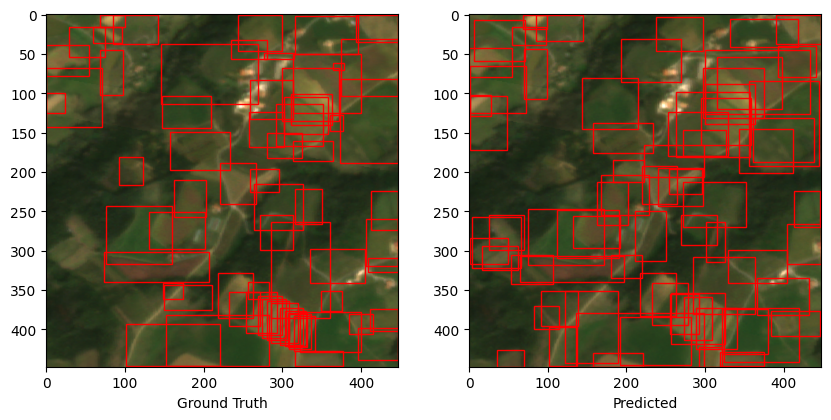

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(image.cpu().permute(1, 2, 0))
ax[0].set_xlabel('Ground Truth')

for i in range (len(targets['boxes'])):
    xmin = targets['boxes'][i][0]
    ymin = targets['boxes'][i][1]
    xmax = targets['boxes'][i][2]
    ymax = targets['boxes'][i][3]
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)

ax[1].imshow(image.cpu().permute(1, 2, 0))
ax[1].set_xlabel('Predicted')

for i in range (len(predictions[0]['boxes'])):
    xmin = predictions[0]['boxes'][i][0]
    ymin = predictions[0]['boxes'][i][1]
    xmax = predictions[0]['boxes'][i][2]
    ymax = predictions[0]['boxes'][i][3]
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)

plt.show()


